<a href="https://colab.research.google.com/github/mattshu0410/Peripheral-Blood-Deep-Learning/blob/main/FastAI_Blood_Cell_Categorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 


In [ ]:
from fastai.vision.all import *
from fastai.callback import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import fastai
fastai.__version__

'2.5.3'

# Ingesting Data

*   Mount the Google Drive.
*   Unzip to working directory
*   Ingest and label images





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

!unzip gdrive/MyDrive/Colab\ Notebooks/PBC_dataset_normal_DIB.zip


In [ ]:
path = "/content/PBC_dataset_normal_DIB"
files = get_image_files(path) #returns paths of all images found within path
len(files)

#Below is if fine grained label based on file names
cell_type = {
    "BA": "Basophil",
    "EO": "Eosinophil",
    "ERB": "Erythroblast",
    "IG": "IG",
    "MMY": "IG",
    "MY": "IG",
    "PMY": "IG",
    "LY": "Lymphocyte",
    "MO": "Monocyte",
    "BNE": "Neutrophil",
    "SNE": "Neutrophil",
    "NEUTROPHIL": "Neutrophil",
    "PLATELET": "Platelet"
}

def label_func(f):
  key = f.split("_")[0] #grabs prefix of file
  return(cell_type[key]) #grab label from cell type dictionary

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(360), valid_pct=0.2)

{'Basophil': 0,
 'Eosinophil': 1,
 'Erythroblast': 2,
 'IG': 3,
 'Lymphocyte': 4,
 'Monocyte': 5,
 'Neutrophil': 6,
 'Platelet': 7}

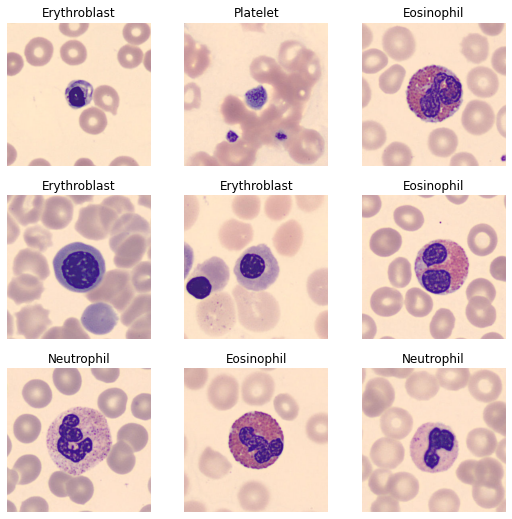

In [ ]:
dls.show_batch()
dls.vocab
dls.vocab.o2i

# Train Model

Need to explain resnet34 architecture.
Metrics used:


*   Accuracy
*   Error Rate
*   Precision (more weight given to larger categories)
*   Recall (more weight given to large categories)
*   F1 Score (more weight given to large categories)
*   RocAuc

N.B. Micro average used because of class imbalance in training dataset. See referenced article:

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate, Precision(average="micro"), Recall(average="micro"), F1Score(average="micro"), RocAuc(average="macro", multi_class="ovo")])

In [ ]:
learn.fit_one_cycle(4)
learn.save('stage_1')

epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.458434,0.151476,0.946460,0.053540,0.946460,0.946460,0.946460,0.997244,04:42
1,0.130515,0.100699,0.966355,0.033645,0.966355,0.966355,0.966355,0.998795,04:42
2,0.087416,0.075025,0.975424,0.024576,0.975424,0.975424,0.975424,0.999383,04:41
3,0.045499,0.064546,0.975717,0.024283,0.975717,0.975717,0.975717,0.999520,04:40


Path('/content/PBC_dataset_normal_DIB/models/stage_1.pth')

# Evaluate Model

Here we reload a previously trained CNN.


*   Learning Rate finder allows you to find optimal learning rate to converge. A excessively high learning rate produces instability. An excessively low learning rate produces training that never converges.
*   A frozen layer is essentially a layer that does not learn during back-propagation. Unfreezing all layers allows them to learn again.

Prediction Memory Issue (UNRESOLVED)
https://forums.fast.ai/t/learn-get-preds-memory-inefficiency-quick-fix/84029/20


In [ ]:
#learn = cnn_learner(dls, resnet34, metrics=error_rate)
#learn.load('stage_1');
#interp = ClassificationInterpretation.from_learner(learn) #interpretations from model
#losses,idxs = interp.top_losses() #worst predictions

SuggestedLRs(valley=0.0003311311302240938)

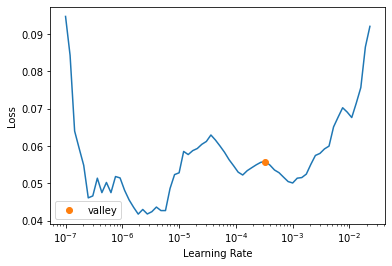

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.load('stage_1');
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=3.3e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.242357,0.374168,0.091281,06:21
1,0.122957,0.219772,0.060854,06:17
2,0.051330,0.050436,0.016384,06:17
3,0.018325,0.035397,0.011118,06:17


In [ ]:
learn.summary()

Sequential (Input shape: 64 x 3 x 360 x 360)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 180 x 180 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 90 x 90   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, preds, targs, decoded, losses): store_attr()

    def __getitem__(self, idxs):
        "Get the the inputs, preds, targs, decoded outputs, and losses at `idxs`"
        if isinstance(idxs, Tensor): idxs = idxs.tolist()
        if not is_listy(idxs): idxs = [idxs]
        attrs = 'preds,targs,decoded,losses'
        res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
        # Gather and preprocess inputs without needing all of them in memory
        inps = [self.dl.do_item(o)[:self.dl.n_inp] for o in idxs]
        inps = self.dl.after_batch(to_device(self.dl.do_batch(inps), self.dl.device))
        return inps + res

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=False, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        inps, preds, targs, decoded, _ = self[idx]
        if not isinstance(inps, tuple): inps = (inps,)
        b = inps + (targs,)
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + (decoded,)
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), preds, losses,  **kwargs)

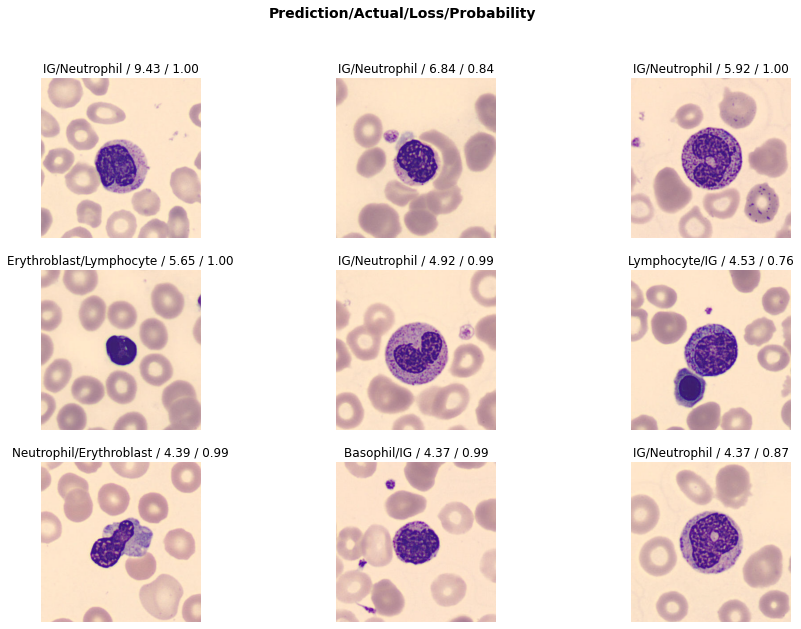

In [ ]:
interp = Interpretation.from_learner(learn) #interpretations from model
interp.plot_top_losses(9, figsize=(15,10)) #worst predictions
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Export Model

Just so I don't have to retrain it every time.

In [ ]:
learn.export()

In [ ]:
path = "/content/PBC_dataset_normal_DIB/export.pkl"
learn = load_learner(path)

In [ ]:
learn.predict("/content/PBC_dataset_normal_DIB/basophil/BA_100102.jpg")

('Basophil',
 TensorBase(0),
 TensorBase([9.1284e-01, 4.6600e-07, 6.8423e-04, 2.0740e-05, 8.6445e-02, 2.9480e-06,
         1.7611e-06, 1.4565e-06]))

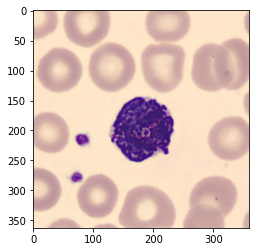

In [ ]:
img = mpimg.imread("/content/PBC_dataset_normal_DIB/basophil/BA_100102.jpg")
imgplot = plt.imshow(img)